<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_Test_Opening_Price_LSTM_CNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf

In [28]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=15f8273d486fa37a0ef3493ae0b7f77a754c289e26676ed2a0f2dd516b5e5d7a
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [29]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [30]:
import yfinance as yf
daily_data = yf.download(tickers='AAPL', period = '1000wk', interval = '1d')
daily_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-08-28,0.264286,0.270000,0.261607,0.262500,0.225387,247973600
2002-08-29,0.261607,0.269286,0.259107,0.262500,0.225387,164169600
2002-08-30,0.263036,0.270357,0.260357,0.263393,0.226154,193519200
2002-09-03,0.258750,0.259821,0.250893,0.250893,0.215421,276936800
2002-09-04,0.253571,0.263929,0.253036,0.258571,0.222013,420660800
...,...,...,...,...,...,...
2021-10-21,148.809998,149.639999,147.869995,149.479996,149.479996,61421000
2021-10-22,149.690002,150.179993,148.639999,148.690002,148.690002,58839600
2021-10-25,148.679993,149.369995,147.619995,148.639999,148.639999,50720600


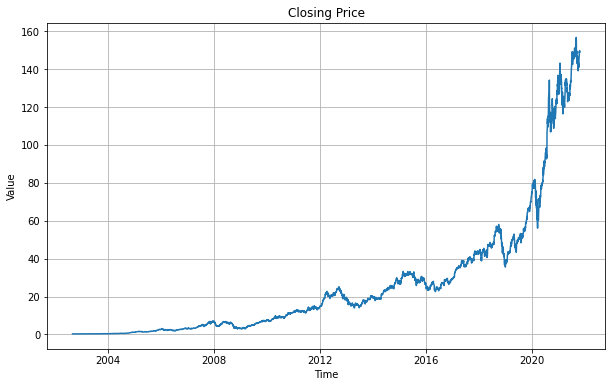

'series = np.array(daily_data.Open)\ntime = np.array(daily_data.index)\nplt.figure(figsize=(10, 6))\nplt.title("Opening Price")\nplot_series(time, series)'

In [31]:
#from sklearn.preprocessing import StandardScaler

#series = one_d_data['Close'].values.reshape(-1, 1)
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()

series = np.array(daily_data.Close)
time = np.array(daily_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.title("Closing Price")
plt.show()

"""series = np.array(daily_data.Open)
time = np.array(daily_data.index)
plt.figure(figsize=(10, 6))
plt.title("Opening Price")
plot_series(time, series)"""

In [40]:
split_time = 4500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [41]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [42]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4500,)
Epoch 1/100
18/18 [==============================] - 5s 57ms/step - loss: 29.7423 - mae: 30.2299
Epoch 2/100
18/18 [==============================] - 1s 62ms/step - loss: 28.7098 - mae: 29.1975
Epoch 3/100
18/18 [==============================] - 1s 62ms/step - loss: 27.5774 - mae: 28.0668
Epoch 4/100
18/18 [==============================] - 1s 60ms/step - loss: 26.2126 - mae: 26.7039
Epoch 5/100
18/18 [==============================] - 1s 63ms/step - loss: 24.4843 - mae: 24.9765
Epoch 6/100
18/18 [==============================] - 1s 63ms/step - loss: 22.0863 - mae: 22.5796
Epoch 7/100
18/18 [==============================] - 1s 61ms/step - loss: 19.1870 - mae: 19.6816
Epoch 8/100
18/18 [==============================] - 1s 61ms/step - loss: 16.7420 - mae: 17.2350
Epoch 9/100
18/18 [==============================] - 1s 62ms/step - loss: 14.7854 - mae: 15.2786
Epoch 10/100
18/18 [=====

(1e-08, 1e-05, 0.0, 25.0)

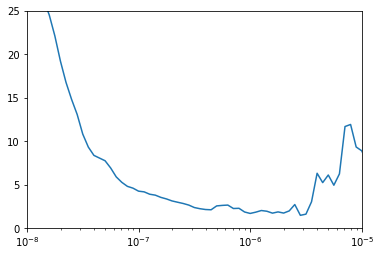

In [44]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-5, 0, 25])

In [45]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
45/45 [==============================] - 6s 37ms/step - loss: 7.3654 - mae: 7.8500
Epoch 2/150
45/45 [==============================] - 2s 38ms/step - loss: 4.6459 - mae: 5.1214
Epoch 3/150
45/45 [==============================] - 2s 40ms/step - loss: 3.8888 - mae: 4.3537
Epoch 4/150
45/45 [==============================] - 2s 38ms/step - loss: 6.3861 - mae: 6.8705
Epoch 5/150
45/45 [==============================] - 2s 38ms/step - loss: 5.1963 - mae: 5.6805
Epoch 6/150
45/45 [==============================] - 2s 39ms/step - loss: 1.5505 - mae: 1.9836
Epoch 7/150
45/45 [==============================] - 2s 38ms/step - loss: 2.1742 - mae: 2.6274
Epoch 8/150
45/45 [==============================] - 2s 39ms/step - loss: 2.6020 - mae: 3.0746
Epoch 9/150
45/45 [==============================] - 2s 38ms/step - loss: 3.2228 - mae: 3.6776
Epoch 10/150
45/45 [==============================] - 2s 38ms/step - loss: 1.9278 - mae: 2.3835
Epoch 11/150
45/45 [=============================

In [46]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

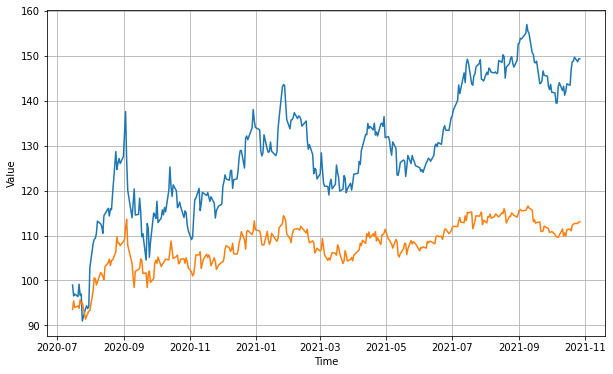

In [19]:
#Opening
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

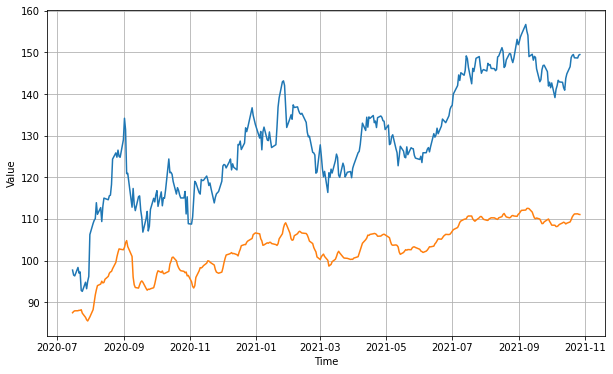

In [47]:
#Closing
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.172106

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS